# Dealing with imbalanced data sets (credicard.csv)

In [15]:
from dtreeviz.trees import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [36]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3
df = pd.read_csv("../../data/creditcard.csv")

In [37]:
print(f"num anomalies {np.sum(df['Class']==1)}/{len(df)} = {100*np.sum(df['Class']==1)/len(df):.2f}%")

num anomalies 492/284807 = 0.17%


## Try usual train/test split

In [35]:
X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight=None)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
print(f"F1 {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy {accuracy_score(y_test, y_pred):.2f}")

[[56862     3]
 [   23    74]]
F1 0.85
Accuracy 1.00


## Oversample fraud

In [43]:
# must split out test set first but get 20% from each class at original ratio of fraud/good
df_good = df[df['Class']==0]
df_fraud = df[df['Class']==1]

df_train_good, df_test_good   = train_test_split(df_good, test_size=0.20)
df_train_fraud, df_test_fraud = train_test_split(df_fraud, test_size=0.20)

df_train = pd.concat([df_train_good, df_train_fraud], axis=0)
df_test  = pd.concat([df_test_good, df_test_fraud], axis=0)

print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num anomalies 393/284807 = 0.17%
TEST num anomalies 99/284807 = 0.17%


In [44]:
X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight=None)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
print(f"F1 {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy {accuracy_score(y_test, y_pred):.2f}")

[[56858     5]
 [   25    74]]
F1 0.83
Accuracy 1.00


In [47]:
# Now, upsample the fraud records in training set
df_good = df_train[df_train['Class']==0]
df_fraud = df_train[df_train['Class']==1]

df_fraud_balanced = df_fraud.sample(len(df_good), replace=True)
df_train_upsampled = pd.concat([df_good, df_fraud_balanced], axis=0)
print(f"Upsampled TRAIN num fraud {np.sum(df_train_upsampled['Class']==1)}/{len(df_train_upsampled)} = {100*np.sum(df_train_upsampled['Class']==1)/len(df_train_upsampled):.2f}%")
df_train_upsampled.head()

Upsampled TRAIN num anomalies 227452/454904 = 50.00%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
40939,40470.0,1.178869,0.494365,-0.384398,0.717791,0.184925,-0.737492,0.208155,-0.035124,-0.410331,...,-0.047346,-0.091512,-0.034821,0.132610,0.435393,0.368906,-0.022175,0.024751,0.76,0
195760,131209.0,-0.696373,0.157378,0.521731,-1.323716,0.131467,-0.322987,0.973868,-0.342287,-1.074189,...,-0.654959,-1.260342,-0.274677,0.695232,0.877088,-0.768007,-0.213513,-0.138949,120.00,0
225314,144201.0,-0.726758,1.090164,-0.820551,-0.543217,1.312874,0.700273,0.772019,0.459250,-0.379599,...,0.406200,1.540002,-0.099986,-1.405774,-0.624344,-0.083982,0.130518,-0.022162,49.32,0
74993,55849.0,0.409258,-2.093026,0.996587,1.345049,-1.813880,0.891232,-0.627933,0.111745,0.344773,...,-0.304925,-0.853129,-0.423365,-0.081009,0.369879,-0.338976,0.048484,0.114029,443.43,0
242619,151569.0,0.097215,1.149349,-1.244381,-1.010788,2.123798,-0.882644,1.545892,-0.579377,0.175234,...,0.149121,0.803163,-0.440366,-1.337407,-0.702794,-0.416264,-0.191058,-0.157664,1.00,0


In [32]:
X, y = df_train.drop('Class', axis=1), df_train['Class']
print(f"num anomalies {len(df_train['Class']==1)}/{len(df_train)}")

num anomalies 227845/227845


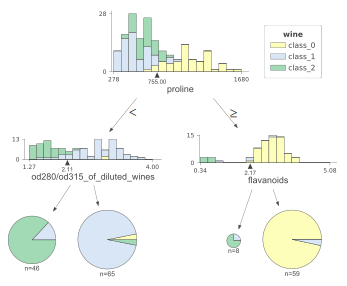

In [93]:
clf.fit(X_train, y_train)

# pick random X observation for demo
X = wine.data[np.random.randint(0, len(wine.data)),:]

viz = dtreeviz(clf,
               wine.data,
               wine.target,
               target_name='wine',
               feature_names=wine.feature_names,
               class_names=list(wine.target_names))
viz